In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = "ecommerce retail.xlsx"

In [ ]:
# Load raw transactional data from the correct sheet
df_raw = pd.read_excel(file_path, sheet_name="ecommerce retail")

In [ ]:
# Create a working copy
df = df_raw.copy()

In [ ]:
# Quick sanity checks
print("Raw shape:", df.shape)
df.head()

Raw shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [ ]:
# Ensure InvoiceDate is a proper datetime type
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

In [ ]:
# Convert CustomerID to numeric
df["CustomerID"] = pd.to_numeric(df["CustomerID"], errors="coerce")

In [ ]:
# check data types
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [ ]:
# 1) Remove rows without CustomerID
# RFM is customer-based; without CustomerID we cannot assign transactions to a customer
df = df.dropna(subset=["CustomerID"])

In [ ]:
# 2) Remove canceled invoices
# InvoiceNo starting with 'C' indicates cancellations in this dataset
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df = df[~df["InvoiceNo"].str.startswith("C")]

In [ ]:
# 3) Remove non-positive quantities (returns or invalid transactions)
df = df[df["Quantity"] > 0]

In [ ]:
# 4) Remove non-positive unit prices (invalid or adjustments)
df = df[df["UnitPrice"] > 0]

In [ ]:
print("Cleaned shape:", df.shape)

Cleaned shape: (397884, 8)


In [ ]:
# Create total transaction value per row (line item revenue)
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

In [ ]:
# sanity checks
print("TotalAmount min:", df["TotalAmount"].min())
print("TotalAmount max:", df["TotalAmount"].max())
df.head()

TotalAmount min: 0.001
TotalAmount max: 168469.6


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
# Summarize how much data was removed (portfolio-friendly summary)
report = pd.DataFrame({
    "Stage": ["Raw", "After Cleaning"],
    "Rows": [len(df_raw), len(df)]
})

report["Removed Rows"] = report["Rows"].iloc[0] - report["Rows"]
report

,Stage,Rows,Removed Rows
0,Raw,541909,0
1,After Cleaning,397884,144025


In [ ]:
# Define the expected transaction grain
# One row represents one product (StockCode) in one invoice (InvoiceNo)
# for one customer at a specific time
grain_cols = ["InvoiceNo", "StockCode", "InvoiceDate", "CustomerID"]

In [ ]:
# Identify potential duplicate rows at transaction grain level
dup_mask = df.duplicated(subset=grain_cols, keep=False)
duplicates = df[dup_mask]

duplicates.shape

(19148, 9)

In [ ]:
# Analyze duplicate patterns to decide whether consolidation is safe
dup_analysis = (
    duplicates
    .groupby(grain_cols)
    .agg(
        row_count=("Quantity", "size"),
        qty_min=("Quantity", "min"),
        qty_max=("Quantity", "max"),
        price_min=("UnitPrice", "min"),
        price_max=("UnitPrice", "max"),
        total_amount_sum=("TotalAmount", "sum")
    )
    .reset_index()
)

dup_analysis.head()

,InvoiceNo,StockCode,InvoiceDate,CustomerID,row_count,qty_min,qty_max,price_min,price_max,total_amount_sum
0,536381,71270,2010-12-01 09:41:00,15311.0,2,1,3,1.25,1.25,5.0
1,536409,21866,2010-12-01 11:45:00,17908.0,2,1,1,1.25,1.25,2.5
2,536409,22111,2010-12-01 11:45:00,17908.0,2,1,1,4.95,4.95,9.9
3,536409,22866,2010-12-01 11:45:00,17908.0,2,1,1,2.10,2.10,4.2
4,536409,22900,2010-12-01 11:45:00,17908.0,2,1,1,2.95,2.95,5.9


In [ ]:
# Duplicates with consistent UnitPrice (safe to consolidate)
safe_dups = dup_analysis[dup_analysis["price_min"] == dup_analysis["price_max"]]

# Duplicates with inconsistent UnitPrice (keep as-is)
unsafe_dups = dup_analysis[dup_analysis["price_min"] != dup_analysis["price_max"]]

safe_dups.shape, unsafe_dups.shape

((9024, 10), (86, 10))

In [ ]:
# Consolidate duplicate line items only when UnitPrice is consistent
group_cols = ["InvoiceNo", "StockCode", "InvoiceDate", "CustomerID", "UnitPrice", "Country"]

df_consolidated = (
    df
    .groupby(group_cols, as_index=False)
    .agg(
        Description=("Description", "first"),
        Quantity=("Quantity", "sum"),
        TotalAmount=("TotalAmount", "sum")
    )
)

df_consolidated.shape

(387938, 9)

In [ ]:
# Ensure no negative or zero values were introduced
df_consolidated[["Quantity", "TotalAmount"]].describe()

,Quantity,TotalAmount
count,387938.000000,387938.000000
mean,13.321232,22.971217
std,181.648882,313.006377
min,1.000000,0.001000
25%,2.000000,4.980000
50%,6.000000,12.500000
75%,12.000000,19.800000
max,80995.000000,168469.600000


In [ ]:
# Compare row counts before vs after consolidation
pd.DataFrame({
    "Stage": ["Before Consolidation", "After Consolidation"],
    "Rows": [len(df), len(df_consolidated)]
})

,Stage,Rows
0,Before Consolidation,397884
1,After Consolidation,387938


In [ ]:
# Replace working dataframe with consolidated version
df = df_consolidated.copy()

In [ ]:
# Define the reference date for Recency calculation
# As specified in the project requirement, Recency is calculated as of 2011-12-31
analysis_date = pd.Timestamp("2011-12-31")

In [ ]:
# Aggregate transactional data to customer level to compute RFM metrics
rfm = (
    df
    .groupby("CustomerID")
    .agg(
        # Recency: days since the most recent purchase
        Recency=("InvoiceDate", lambda x: (analysis_date - x.max()).days),

        # Frequency: number of unique invoices per customer
        Frequency=("InvoiceNo", "nunique"),

        # Monetary: total spending per customer
        Monetary=("TotalAmount", "sum")
    )
    .reset_index()
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,346,1,77183.60
1,12347.0,23,7,4310.00
2,12348.0,96,4,1797.24
3,12349.0,39,1,1757.55
4,12350.0,331,1,334.40


In [ ]:
# Check the shape of the RFM table
rfm.shape

(4338, 4)

In [ ]:
# Inspect basic statistics of RFM metrics
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,113.059474,4.272015,2054.266460
std,1721.808492,100.012264,7.697998,8989.230441
min,12346.000000,21.000000,1.000000,3.750000
25%,13813.250000,38.000000,1.000000,307.415000
50%,15299.500000,71.000000,2.000000,674.485000
75%,16778.750000,162.750000,5.000000,1661.740000
max,18287.000000,394.000000,209.000000,280206.020000


In [ ]:
# Ensure there is exactly one row per customer
rfm["CustomerID"].duplicated().sum()

np.int64(0)

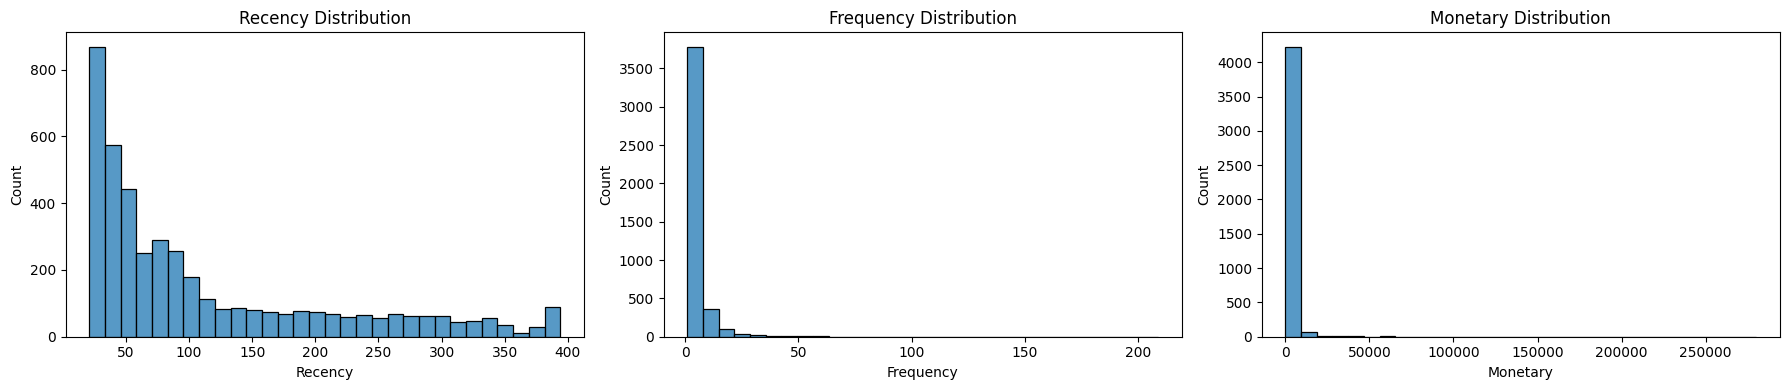

In [ ]:
# Visualize distributions of RFM metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.tight_layout()
plt.show()

In [ ]:
# Assign Recency score using quintiles
# Customers with more recent purchases receive higher scores
rfm["R_Score"] = pd.qcut(
    rfm["Recency"],
    5,
    labels=[5, 4, 3, 2, 1]
)

In [ ]:
# Assign Frequency score using quintiles
# Ranking is applied to avoid issues with tied values
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"),
    5,
    labels=[1, 2, 3, 4, 5]
)

In [ ]:
# Assign Monetary score using quintiles
rfm["M_Score"] = pd.qcut(
    rfm["Monetary"].rank(method="first"),
    5,
    labels=[1, 2, 3, 4, 5]
)

In [ ]:
# Convert RFM scores from categorical to integer
rfm[["R_Score", "F_Score", "M_Score"]] = rfm[
    ["R_Score", "F_Score", "M_Score"]
].astype(int)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346.0,346,1,77183.60,1,1,5
1,12347.0,23,7,4310.00,5,5,5
2,12348.0,96,4,1797.24,2,4,4
3,12349.0,39,1,1757.55,4,1,4
4,12350.0,331,1,334.40,1,1,2


In [ ]:
# Combine R, F, and M scores into a single RFM code
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,346,1,77183.60,1,1,5,115
1,12347.0,23,7,4310.00,5,5,5,555
2,12348.0,96,4,1797.24,2,4,4,244
3,12349.0,39,1,1757.55,4,1,4,414
4,12350.0,331,1,334.40,1,1,2,112


In [ ]:
# Check distribution of RFM scores
rfm[["R_Score", "F_Score", "M_Score"]].describe()

,R_Score,F_Score,M_Score
count,4338.000000,4338.00000,4338.00000
mean,3.006455,3.00000,3.00000
std,1.413220,1.41454,1.41454
min,1.000000,1.00000,1.00000
25%,2.000000,2.00000,2.00000
50%,3.000000,3.00000,3.00000
75%,4.000000,4.00000,4.00000
max,5.000000,5.00000,5.00000


In [ ]:
rfm[["R_Score", "F_Score", "M_Score"]].value_counts().sort_index()

R_Score  F_Score  M_Score
1        1        1          182
                  2          127
                  3           32
                  4           17
                  5            4
                            ... 
5        5        1            1
                  2            1
                  3            8
                  4           81
                  5          348
Name: count, Length: 117, dtype: int64

In [ ]:
rfm["RFM_Score"].value_counts().head(10)

,count
RFM_Score,
555,348
111,182
455,175
121,153
112,127
444,118
122,92
544,88
233,86


In [ ]:
xls = pd.ExcelFile(file_path)
xls.sheet_names

['ecommerce retail', 'Segmentation']

In [ ]:
# Load segmentation mapping table provided in the Excel file
seg_map = pd.read_excel(file_path, sheet_name="Segmentation")

seg_map.head()

,Segment,RFM Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."


In [ ]:
# Build a dictionary mapping each RFM code (e.g., "555") to a segment name
rfm_to_segment = {}

for _, row in seg_map.iterrows():
    segment_name = str(row["Segment"]).strip()
    codes_raw = str(row["RFM Score"])

    # Split codes by comma and clean spaces
    codes = [c.strip() for c in codes_raw.split(",") if c.strip() != ""]

    # Add to dictionary
    for code in codes:
        rfm_to_segment[code] = segment_name

len(rfm_to_segment), list(rfm_to_segment.items())[:5]

(125,
 [('555', 'Champions'),
  ('554', 'Champions'),
  ('544', 'Champions'),
  ('545', 'Champions'),
  ('454', 'Champions')])

In [ ]:
# Ensure RFM_Score is a string of 3 digits (e.g., "115", "555")
rfm["RFM_Score"] = rfm["RFM_Score"].astype(str).str.zfill(3)

# Map segments using the provided framework
rfm["Segment"] = rfm["RFM_Score"].map(rfm_to_segment)

rfm[["CustomerID", "RFM_Score", "Segment"]].head()

,CustomerID,RFM_Score,Segment
0,12346.0,115,Cannot Lose Them
1,12347.0,555,Champions
2,12348.0,244,At Risk
3,12349.0,414,Promising
4,12350.0,112,Lost customers


In [ ]:
# Check if any customers were not mapped to a segment
unmapped = rfm["Segment"].isna().sum()
unmapped

np.int64(0)

In [ ]:
# Count customers per segment
rfm["Segment"].value_counts()

,count
Segment,
Champions,835
Hibernating customers,696
Lost customers,486
Loyal,428
At Risk,422
Potential Loyalist,414
About To Sleep,283
Need Attention,280
New Customers,267


# Note:
# Segments are assigned using the official RFM-to-segment mapping provided by the business (segmentation sheet),
# ensuring full coverage and consistency with marketing definitions.

In [ ]:
seg_map.columns

Index(['Segment', 'RFM Score'], dtype='object')

Customer segments were assigned using the official RFM-to-segment mapping provided in the segmentation sheet, ensuring full customer coverage and alignment with marketing business definitions.


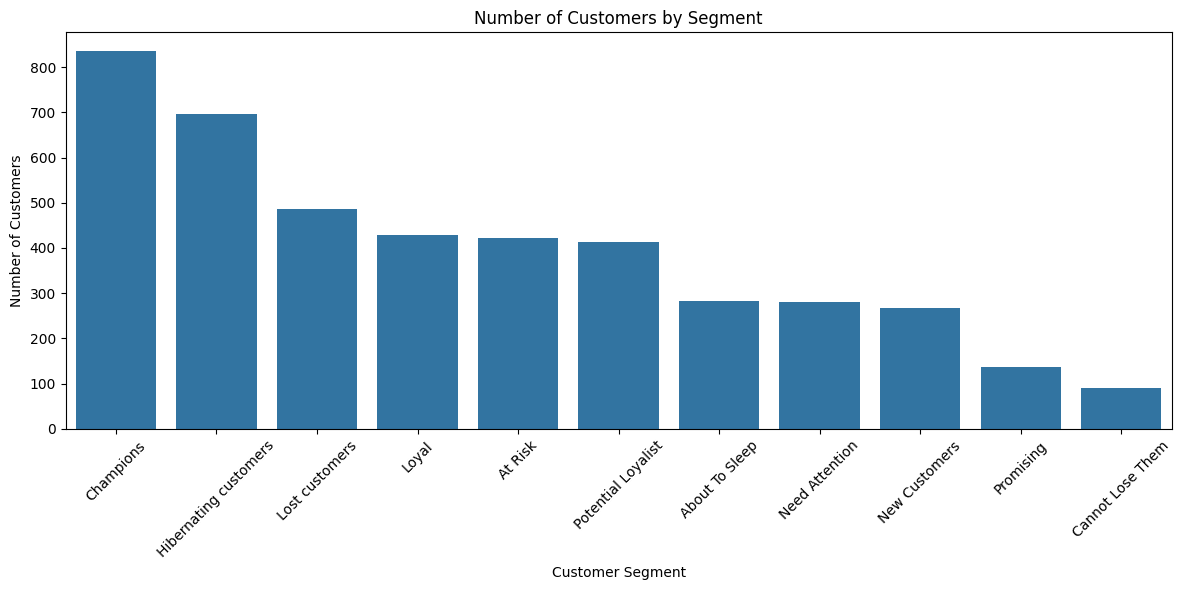

In [ ]:
# Customer count by segment
segment_counts = rfm["Segment"].value_counts().reset_index()
segment_counts.columns = ["Segment", "CustomerCount"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=segment_counts,
    x="Segment",
    y="CustomerCount"
)
plt.title("Number of Customers by Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# This chart shows the distribution of customers across RFM segments,
# helping identify priority customer groups for marketing actions.

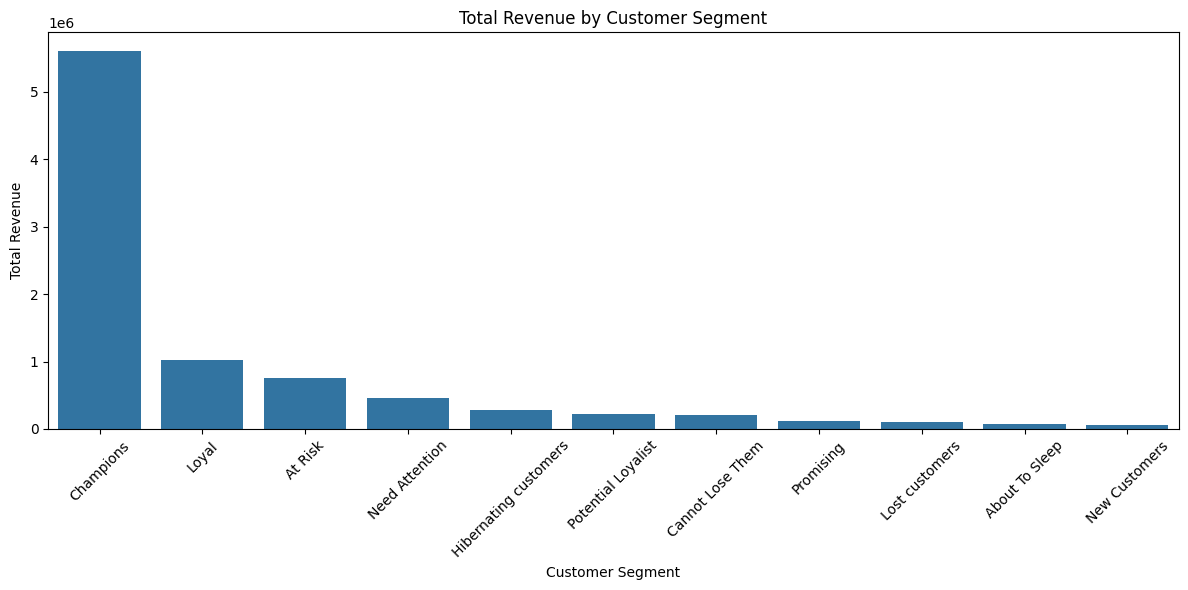

In [ ]:
# Total revenue by segment
segment_revenue = (
    rfm.groupby("Segment")["Monetary"]
    .sum()
    .reset_index()
    .sort_values("Monetary", ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=segment_revenue,
    x="Segment",
    y="Monetary"
)
plt.title("Total Revenue by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Average RFM metrics by segment
segment_rfm_avg = (
    rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .reset_index()
)

segment_rfm_avg

,Segment,Recency,Frequency,Monetary
0,About To Sleep,107.325088,1.282686,275.213922
1,At Risk,164.419431,3.763033,1781.536069
2,Cannot Lose Them,256.230769,2.285714,2238.146154
3,Champions,31.816766,12.113772,6711.828359
4,Hibernating customers,169.916667,1.554598,410.450204
5,Lost customers,296.557613,1.065844,200.423066
6,Loyal,57.070093,5.320093,2386.038294
7,Need Attention,54.350000,3.103571,1652.984789
8,New Customers,48.891386,1.071161,223.803820
9,Potential Loyalist,47.053140,2.526570,545.265966


In [ ]:
# Make plots a bit cleaner
sns.set_context("talk")

In [ ]:
!pip -q install squarify

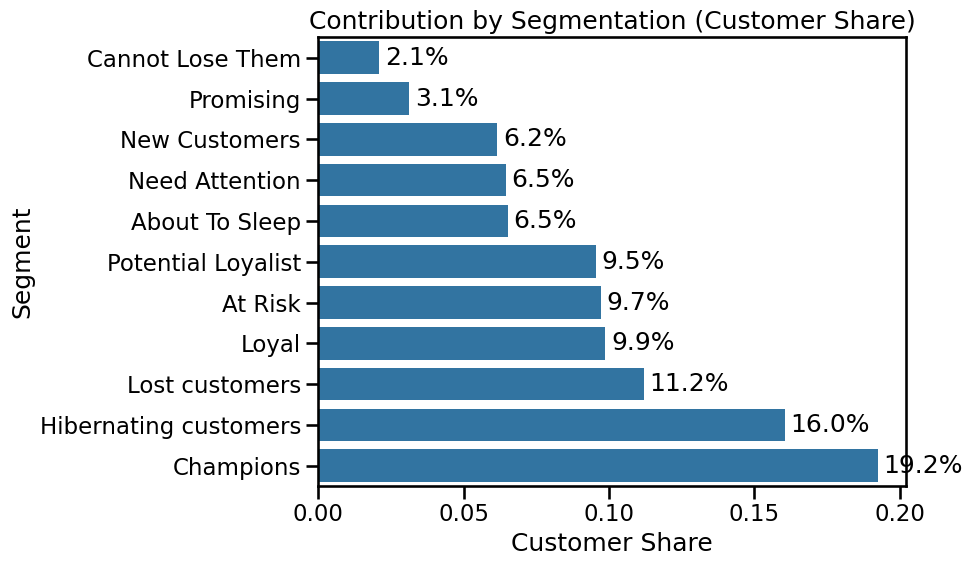

In [ ]:
# Contribution by Segmentation (Customer Share)
seg_cnt = (
    rfm.groupby("Segment")["CustomerID"]
       .count()
       .reset_index(name="Customers")
)

seg_cnt["Share"] = seg_cnt["Customers"] / seg_cnt["Customers"].sum()
seg_cnt = seg_cnt.sort_values("Share", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=seg_cnt, x="Share", y="Segment")

for i, row in seg_cnt.iterrows():
    plt.text(row.Share + 0.002, list(seg_cnt.index).index(i),
             f"{row.Share:.1%}", va="center")

plt.title("Contribution by Segmentation (Customer Share)")
plt.xlabel("Customer Share")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

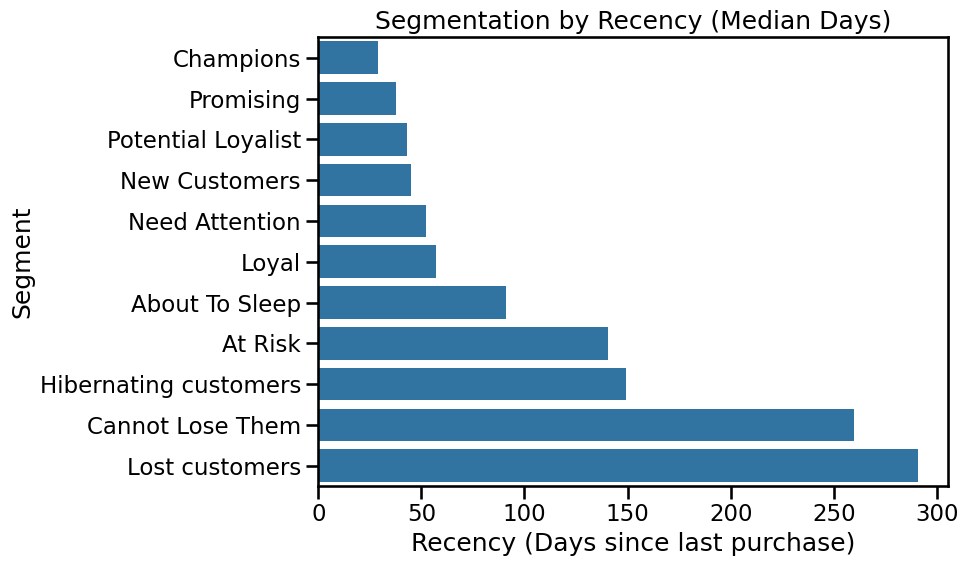

In [ ]:
# Segmentation by Recency (Median)
recency_seg = (
    rfm.groupby("Segment")["Recency"]
       .median()
       .reset_index()
       .sort_values("Recency", ascending=True)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=recency_seg, x="Recency", y="Segment")

plt.title("Segmentation by Recency (Median Days)")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

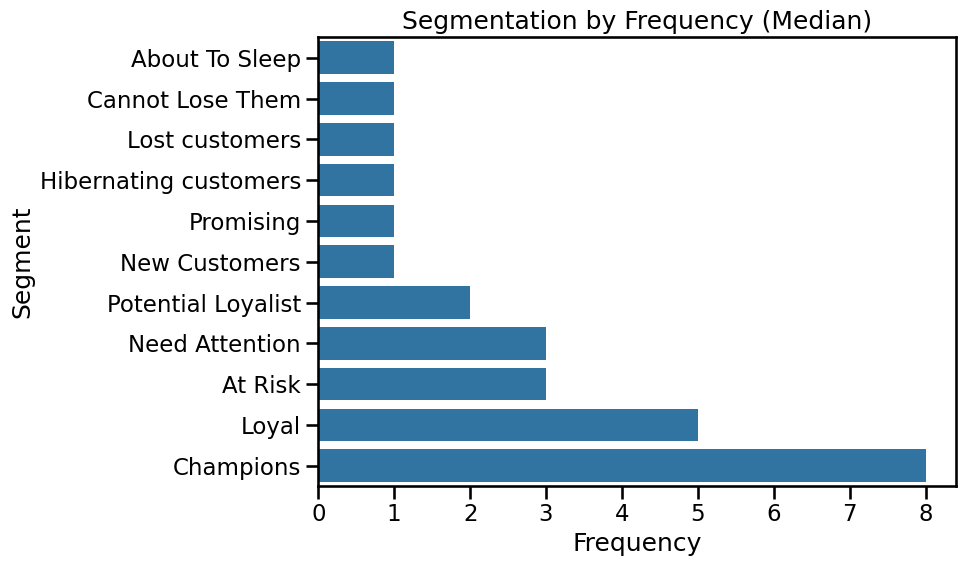

In [ ]:
# Segmentation by Frequency (Median)
freq_seg = (
    rfm.groupby("Segment")["Frequency"]
       .median()
       .reset_index()
       .sort_values("Frequency", ascending=True)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=freq_seg, x="Frequency", y="Segment")

plt.title("Segmentation by Frequency (Median)")
plt.xlabel("Frequency")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

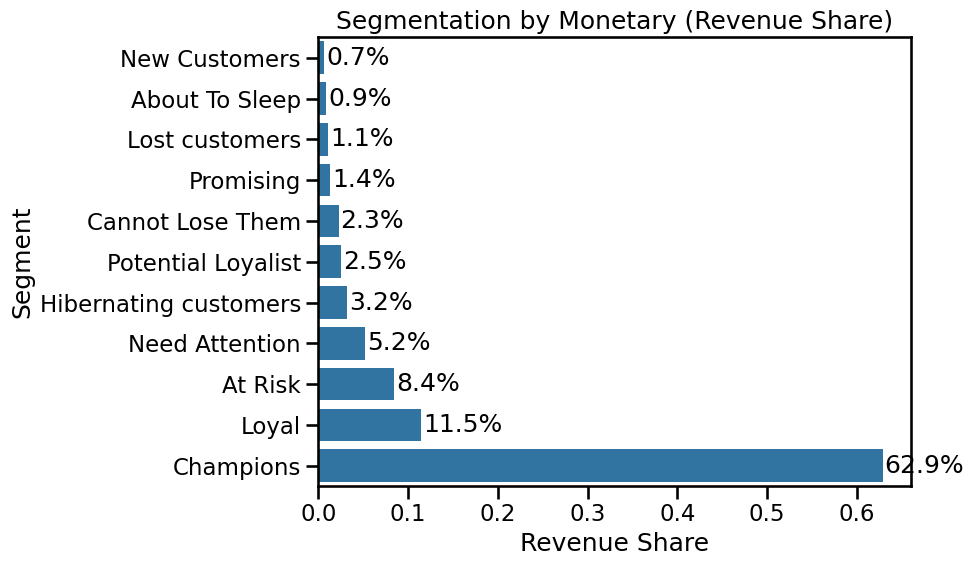

In [ ]:
# Segmentation by Monetary (Revenue Share)
mon_seg = (
    rfm.groupby("Segment")["Monetary"]
       .sum()
       .reset_index(name="Revenue")
)

mon_seg["Share"] = mon_seg["Revenue"] / mon_seg["Revenue"].sum()
mon_seg = mon_seg.sort_values("Share", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=mon_seg, x="Share", y="Segment")

for i, row in mon_seg.iterrows():
    plt.text(row.Share + 0.002, list(mon_seg.index).index(i),
             f"{row.Share:.1%}", va="center")

plt.title("Segmentation by Monetary (Revenue Share)")
plt.xlabel("Revenue Share")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

In [ ]:
# Create Year-Month column
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

# Aggregate monthly metrics
monthly_rfm = (
    df.groupby("InvoiceMonth")
      .agg(
          Monetary=("TotalAmount", "sum"),
          Frequency=("InvoiceNo", "nunique"),
          Recency_proxy=("InvoiceDate", "max")  # proxy for activity
      )
      .reset_index()
)

# Sort by time
monthly_rfm = monthly_rfm.sort_values("InvoiceMonth")
monthly_rfm.head()

,InvoiceMonth,Monetary,Frequency,Recency_proxy
0,2010-12,572713.890,1400,2010-12-23 16:06:00
1,2011-01,569445.040,987,2011-01-31 16:59:00
2,2011-02,447137.350,997,2011-02-28 17:01:00
3,2011-03,595500.760,1321,2011-03-31 19:55:00
4,2011-04,469200.361,1149,2011-04-28 19:53:00


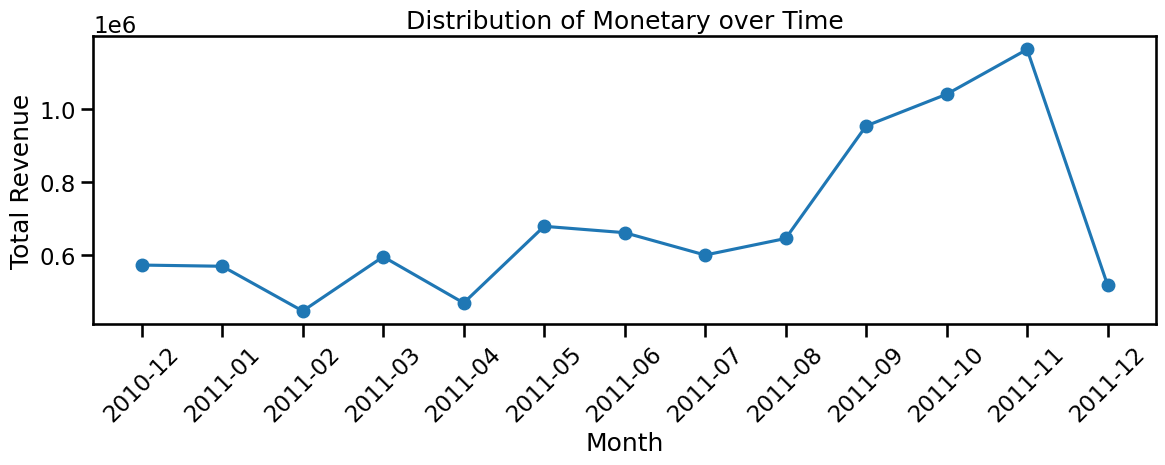

In [ ]:
#Line chart – Monetary over Time
plt.figure(figsize=(12, 5))
plt.plot(monthly_rfm["InvoiceMonth"], monthly_rfm["Monetary"], marker="o")

plt.title("Distribution of Monetary over Time")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

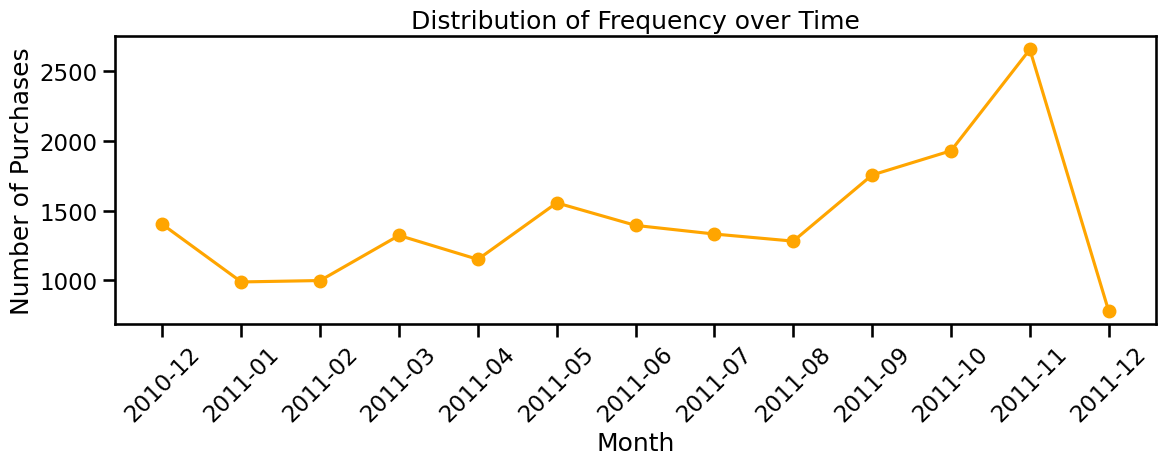

In [ ]:
#Line chart – Frequency over Time
plt.figure(figsize=(12, 5))
plt.plot(monthly_rfm["InvoiceMonth"], monthly_rfm["Frequency"], marker="o", color="orange")

plt.title("Distribution of Frequency over Time")
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


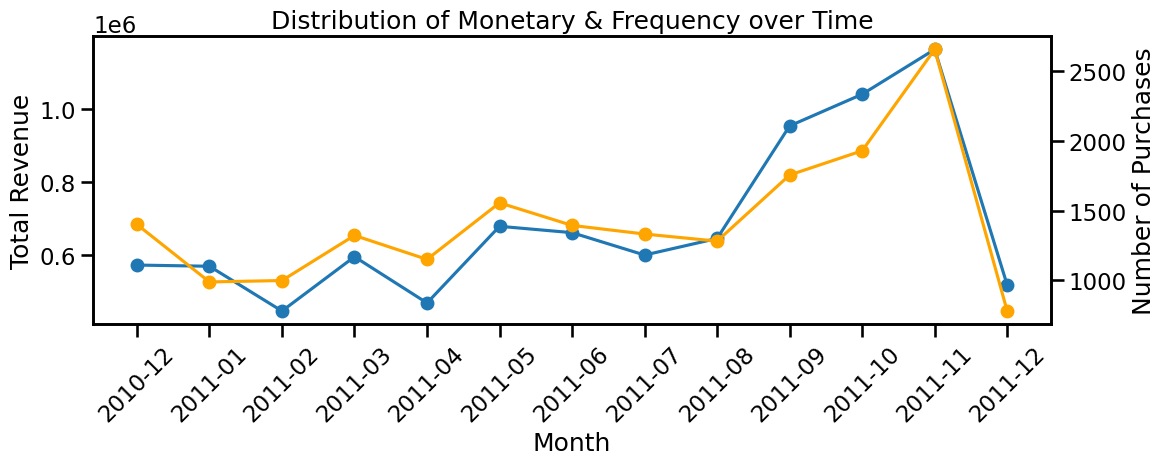

In [ ]:
# Combined Line Chart – Monetary & Frequency (optional nhưng đẹp)
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(monthly_rfm["InvoiceMonth"], monthly_rfm["Monetary"], marker="o", label="Monetary")
ax1.set_ylabel("Total Revenue")

ax2 = ax1.twinx()
ax2.plot(monthly_rfm["InvoiceMonth"], monthly_rfm["Frequency"], marker="o", color="orange", label="Frequency")
ax2.set_ylabel("Number of Purchases")

ax1.set_title("Distribution of Monetary & Frequency over Time")
ax1.set_xlabel("Month")
ax1.tick_params(axis="x", rotation=45)

fig.tight_layout()
plt.show()

📊 Observations – Distribution of RFM over Time

Monetary shows noticeable fluctuations over time, indicating seasonality effects in customer spending behavior. Certain months generate significantly higher revenue than others.

Frequency remains relatively stable across months, suggesting that the number of purchase events does not change drastically, even when revenue fluctuates.

The gap between Monetary and Frequency trends implies that revenue growth is driven more by order value than by purchase volume.

Periods with stable frequency but declining revenue may indicate lower average basket size, while spikes in revenue often correspond to higher-value purchases rather than more customers.

👉 Key takeaway:
While customer purchase activity remains consistent, revenue volatility is primarily influenced by Monetary value, highlighting the importance of pricing, bundling, and upselling strategies.


In [ ]:
# Map 11 segments into 4 strategic groups
group_map = {
    "Champions": "Loyal & High Value",
    "Loyal": "Loyal & High Value",
    "Potential Loyalist": "Loyal & High Value",

    "At Risk": "High Risk Customers",
    "Cannot Lose Them": "High Risk Customers",
    "About To Sleep": "High Risk Customers",
    "Need Attention": "High Risk Customers",

    "New Customers": "New & Potential",
    "Promising": "New & Potential",

    "Hibernating customers": "Inactive & Lost",
    "Lost customers": "Inactive & Lost"
}

# Apply grouping
rfm["Group"] = rfm["Segment"].map(group_map)

rfm["Group"].value_counts()

,count
Group,
Loyal & High Value,1677
Inactive & Lost,1182
High Risk Customers,1076
New & Potential,403


In [ ]:
# Group distribution
group_dist = (
    rfm.groupby("Group")["CustomerID"]
       .count()
       .reset_index(name="Customers")
)

group_dist["Share"] = group_dist["Customers"] / group_dist["Customers"].sum()
group_dist

,Group,Customers,Share
0,High Risk Customers,1076,0.248041
1,Inactive & Lost,1182,0.272476
2,Loyal & High Value,1677,0.386584
3,New & Potential,403,0.092900


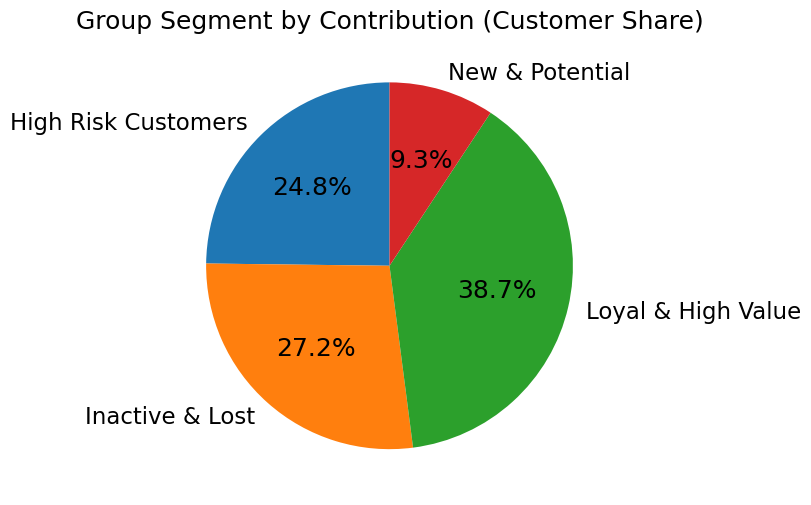

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(
    group_dist["Customers"],
    labels=group_dist["Group"],
    autopct="%.1f%%",
    startangle=90
)
plt.title("Group Segment by Contribution (Customer Share)")
plt.tight_layout()
plt.show()

In [ ]:
# Merge group info into transaction data
df_group = df.merge(
    rfm[["CustomerID", "Group"]],
    on="CustomerID",
    how="left"
)

df_group.head()

,InvoiceNo,StockCode,InvoiceDate,CustomerID,UnitPrice,Country,Description,Quantity,TotalAmount,InvoiceMonth,Group
0,536365,21730,2010-12-01 08:26:00,17850.0,4.25,United Kingdom,GLASS STAR FROSTED T-LIGHT HOLDER,6,25.50,2010-12,High Risk Customers
1,536365,22752,2010-12-01 08:26:00,17850.0,7.65,United Kingdom,SET 7 BABUSHKA NESTING BOXES,2,15.30,2010-12,High Risk Customers
2,536365,71053,2010-12-01 08:26:00,17850.0,3.39,United Kingdom,WHITE METAL LANTERN,6,20.34,2010-12,High Risk Customers
3,536365,84029E,2010-12-01 08:26:00,17850.0,3.39,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,6,20.34,2010-12,High Risk Customers
4,536365,84029G,2010-12-01 08:26:00,17850.0,3.39,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,6,20.34,2010-12,High Risk Customers


In [ ]:
# Top 10 countries by number of customers
top_countries = (
    df_group.groupby("Country")["CustomerID"]
            .nunique()
            .sort_values(ascending=False)
            .head(10)
            .index
)

df_country = df_group[df_group["Country"].isin(top_countries)]

In [ ]:
# Count customers by Country & Group
country_group_dist = (
    df_country.groupby(["Country", "Group"])["CustomerID"]
              .nunique()
              .reset_index(name="Customers")
)

# Pivot for stacked bar
country_pivot = country_group_dist.pivot(
    index="Country",
    columns="Group",
    values="Customers"
).fillna(0)

country_pivot

Group,High Risk Customers,Inactive & Lost,Loyal & High Value,New & Potential
Country,,,,
Austria,3.0,2.0,3.0,3.0
Belgium,7.0,5.0,13.0,0.0
Finland,2.0,1.0,3.0,6.0
France,12.0,23.0,41.0,11.0
Germany,25.0,17.0,40.0,12.0
Italy,1.0,4.0,4.0,5.0
Portugal,3.0,6.0,6.0,4.0
Spain,13.0,3.0,9.0,5.0
Switzerland,9.0,4.0,5.0,3.0


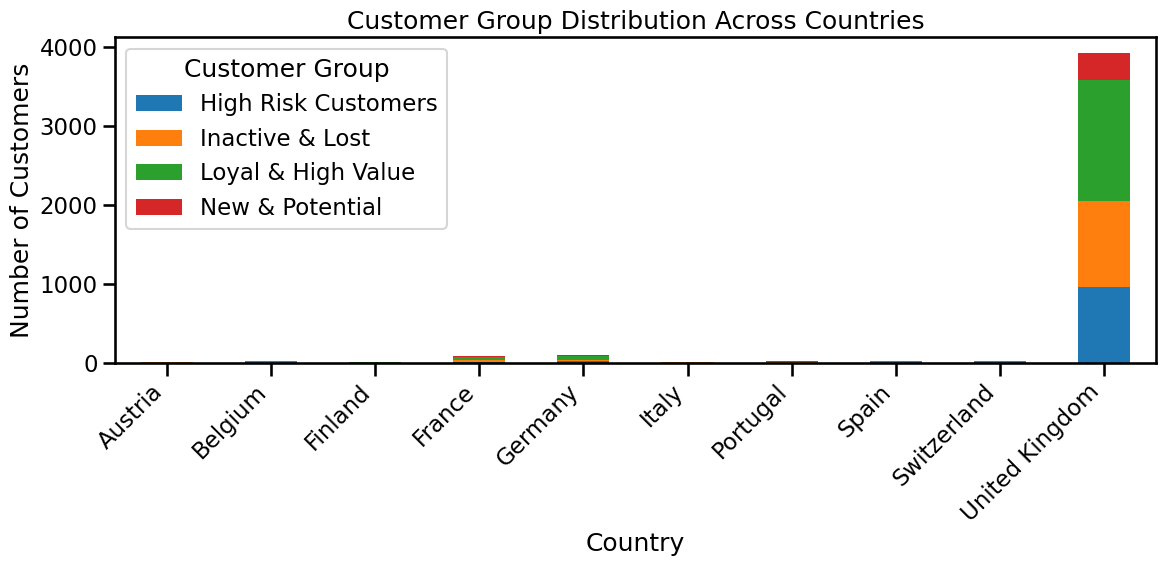

In [ ]:
# Plot stacked bar chart
country_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6)
)

plt.title("Customer Group Distribution Across Countries")
plt.xlabel("Country")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Customer Group")
plt.tight_layout()
plt.show()

In [ ]:
# Ensure InvoiceMonth exists
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

# Merge group into transaction data (if not done already)
df_group = df.merge(
    rfm[["CustomerID", "Group"]],
    on="CustomerID",
    how="left"
)

# Count unique customers by Month & Group
monthly_group_dist = (
    df_group.groupby(["InvoiceMonth", "Group"])["CustomerID"]
            .nunique()
            .reset_index(name="Customers")
)

# Pivot for plotting
monthly_group_pivot = monthly_group_dist.pivot(
    index="InvoiceMonth",
    columns="Group",
    values="Customers"
).fillna(0)

# Sort by time
monthly_group_pivot = monthly_group_pivot.sort_index()

monthly_group_pivot.head()

Group,High Risk Customers,Inactive & Lost,Loyal & High Value,New & Potential
InvoiceMonth,,,,
2010-12,170.0,167.0,540.0,8.0
2011-01,164.0,112.0,460.0,5.0
2011-02,158.0,131.0,468.0,1.0
2011-03,197.0,196.0,578.0,3.0
2011-04,184.0,148.0,524.0,0.0


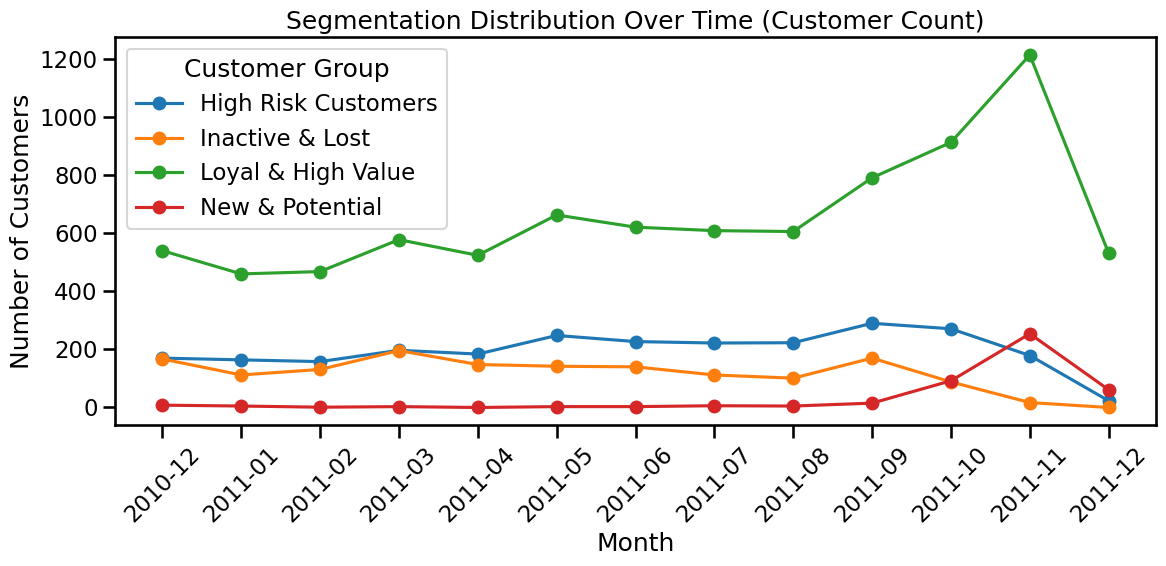

In [ ]:
plt.figure(figsize=(12, 6))

for group in monthly_group_pivot.columns:
    plt.plot(
        monthly_group_pivot.index,
        monthly_group_pivot[group],
        marker="o",
        label=group
    )

plt.title("Segmentation Distribution Over Time (Customer Count)")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.legend(title="Customer Group")
plt.tight_layout()
plt.show()

In [ ]:
# Ensure InvoiceMonth exists
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").astype(str)

# Merge group info
df_group = df.merge(
    rfm[["CustomerID", "Group", "Recency", "Frequency", "Monetary"]],
    on="CustomerID",
    how="left"
)

# Aggregate RFM metrics by Month & Group
monthly_rfm_group = (
    df_group.groupby(["InvoiceMonth", "Group"])
            .agg(
                Recency=("Recency", "mean"),
                Frequency=("InvoiceNo", "nunique"),
                Monetary=("TotalAmount", "sum")
            )
            .reset_index()
)

monthly_rfm_group.head()

,InvoiceMonth,Group,Recency,Frequency,Monetary
0,2010-12,High Risk Customers,196.181574,255,90539.52
1,2010-12,Inactive & Lost,322.382855,172,37514.02
2,2010-12,Loyal & High Value,35.186577,965,442235.30
3,2010-12,New & Potential,34.943182,8,2425.05
4,2011-01,High Risk Customers,195.331574,190,174051.44


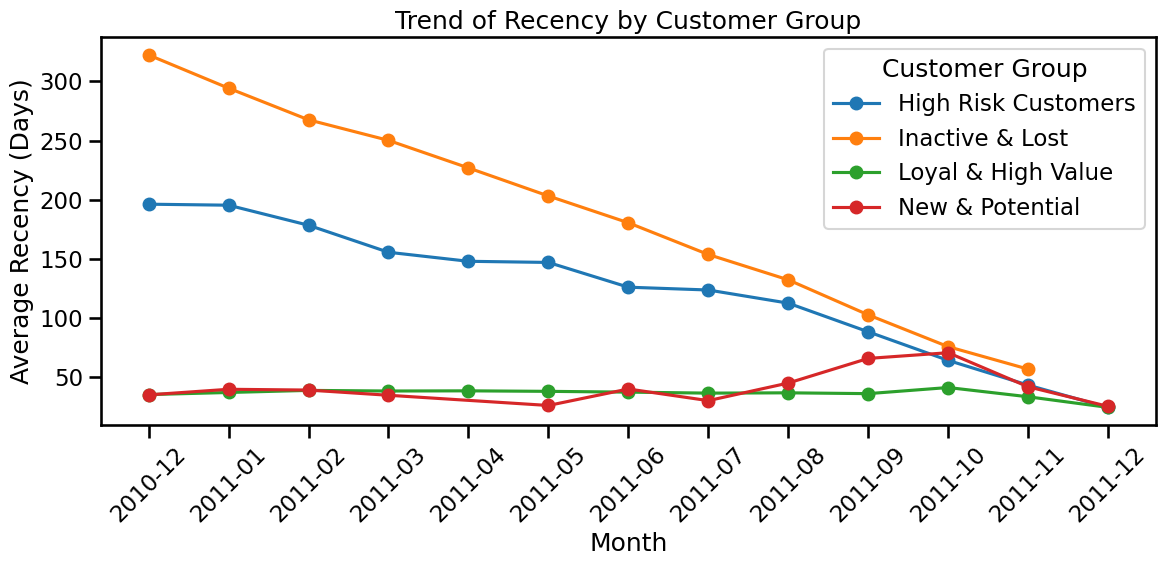

In [ ]:
plt.figure(figsize=(12, 6))

for group in monthly_rfm_group["Group"].unique():
    data = monthly_rfm_group[monthly_rfm_group["Group"] == group]
    plt.plot(data["InvoiceMonth"], data["Recency"], marker="o", label=group)

plt.title("Trend of Recency by Customer Group")
plt.xlabel("Month")
plt.ylabel("Average Recency (Days)")
plt.xticks(rotation=45)
plt.legend(title="Customer Group")
plt.tight_layout()
plt.show()

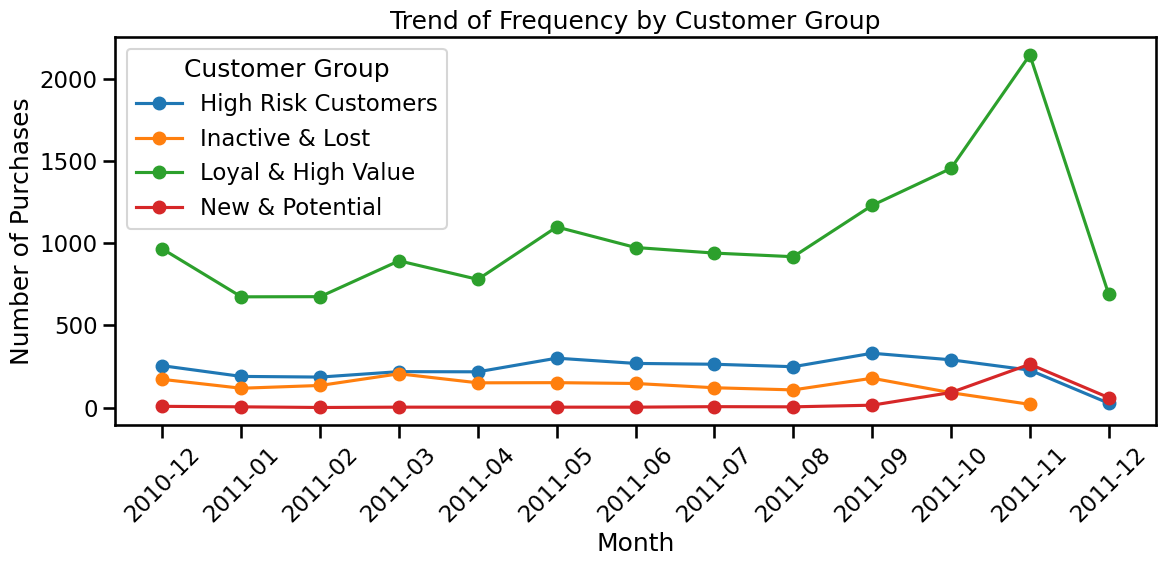

In [ ]:
plt.figure(figsize=(12, 6))

for group in monthly_rfm_group["Group"].unique():
    data = monthly_rfm_group[monthly_rfm_group["Group"] == group]
    plt.plot(data["InvoiceMonth"], data["Frequency"], marker="o", label=group)

plt.title("Trend of Frequency by Customer Group")
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.legend(title="Customer Group")
plt.tight_layout()
plt.show()

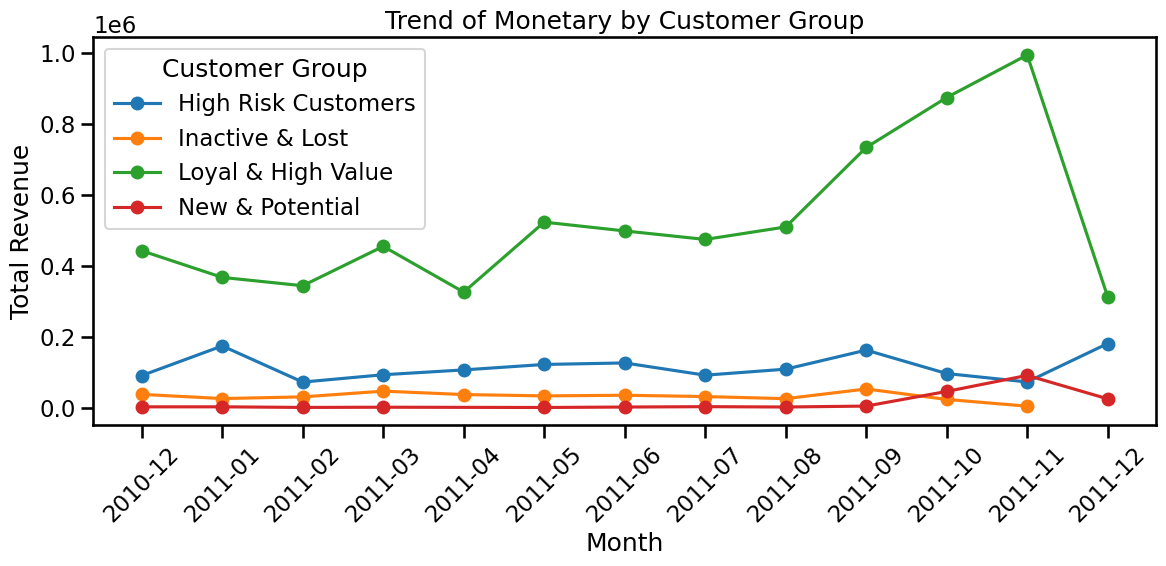

In [ ]:
plt.figure(figsize=(12, 6))

for group in monthly_rfm_group["Group"].unique():
    data = monthly_rfm_group[monthly_rfm_group["Group"] == group]
    plt.plot(data["InvoiceMonth"], data["Monetary"], marker="o", label=group)

plt.title("Trend of Monetary by Customer Group")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.legend(title="Customer Group")
plt.tight_layout()
plt.show()

In [ ]:
# --- Portfolio Quick Snapshot (run this cell and paste the output) ---

# 1) Total unique customers
total_customers = df["CustomerID"].nunique()

# 2) Time range (min/max InvoiceDate)
start_date = df["InvoiceDate"].min()
end_date = df["InvoiceDate"].max()

# 3) Total revenue
total_revenue = df["TotalAmount"].sum()

print("Total unique customers:", total_customers)
print("Time range:", start_date, "to", end_date)
print("Total revenue:", f"{total_revenue:,.2f}")



Total unique customers: 4338
Time range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Total revenue: 8,911,407.90


In [ ]:
total_orders = df["InvoiceNo"].nunique()
total_transactions = len(df)

print("Total orders (unique invoices):", total_orders)
print("Total transactions (rows):", total_transactions)

Total orders (unique invoices): 18532
Total transactions (rows): 387938
